# Final Assignment B
Kamile Stankeviciute `ks830`

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# The Python magic
import IPython
import signal

def interrupted(_interrupted=[False], _default=[None]):
    if _default[0] is None or signal.getsignal(signal.SIGINT) == _default[0]:
        _interrupted[0] = False
        def handle(signal, frame):
            if _interrupted[0] and _default[0] is not None:
                _default[0](signal, frame)
            print('Interrupt!')
            _interrupted[0] = True
        _default[0] = signal.signal(signal.SIGINT, handle)
    return _interrupted[0]

def enumerate_cycle(g):
    epoch = 0
    while True:
        for i,x in enumerate(g):
            yield (epoch,i), x
        epoch = epoch + 1

In [3]:
# Loading the dataset
pd.set_option('display.max_columns', 500)

diabetic = pd.read_csv('diabetes/diabetic_data_original.csv')
diabetic.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
diabetic['encounter_id'].sort_values()

8             12522
9             15738
4             16680
10            28236
5             35754
            ...    
101761    443847548
101762    443847782
101763    443854148
101764    443857166
101765    443867222
Name: encounter_id, Length: 101766, dtype: int64

In [205]:
patient_nbr_counts = diabetic['patient_nbr'].value_counts()
df_diabetic = diabetic[diabetic['patient_nbr'].isin(patient_nbr_counts.index[patient_nbr_counts.gt(1)])].sort_values(['patient_nbr', 'encounter_id'])
pd.set_option('display.max_rows', 25)
print(df_diabetic[['encounter_id', 'patient_nbr', 'readmitted']])

        encounter_id  patient_nbr readmitted
4267        24437208          135        <30
4780        26264286          135        >30
1164         8380170         1152        >30
5953        30180318         1152        >30
14180       55533660         1152        >30
...              ...          ...        ...
99544      414418886    188634893         NO
93050      330256946    188970179        <30
101595     441488168    188970179         NO
90933      302575430    189257846         NO
98191      397823084    189257846        >30

[47021 rows x 3 columns]


## Training task

*For the purposes of this assignment, we wish to predict the `time_in_hospital` value. It doesn’t make sense to predict the duration of a stay in hospital by using attributes recorded during that stay. Instead, we will restrict attention to **follow-on visits**, and seek to predict the length of a stay for follow-on visit on the basis of attributes recorded in the previous visit.*

*Follow-on* visits mean that the model will be trained on *patients who had follow-on visits*. I will select the patients who have been readmitted (only those `patient_nbr`s which appear more than once in the dataset), sort them by time (assuming the `encounter_id` is sorted and sequential), ignoring the patients who have not been readmitted. Then 
* the train instance will contain data from the first visit, 
* the test instance will contain length of stay (`time_in_hospital`) of the next visit


Q: What about the patients which had several follow-ons? Can the first follow-up (ground truth for the initial visit) be a training instance, with the second follow-up having the ground truth? Is there data leakage? A: No as long as just the time in hospital is given.

Q: Can I use the length of stay of the current visit as a feature? A: Yes, why not.

## Data preparation

*Don’t explain the code you used, but do explain what filtering or processing you applied, and report how many items there are in your dataset.*

* Patient with follow-on visits selection.
* Generating predicted variable (`next_time_in_hospital`) by extracting the `time_in_hospital` of the same `patient_nbr` from the next `encounter_id`.
* Scaling (normalisation): important for training stability.
* Categorial variable one-hot coding.
* Handling missing data: masks and codes.
* Feature engineering and selection should not be necessary with a deep learning framework, which, with sufficient model complexity, should learn to extract those features by itself.

**Q: Can I assume `encounter_id`s are chronological? A: assumption is reasonable as manually looking at the dataset with sorted encounters and patient identifiers all entries have readmitted outcome but the last outcome is of not readmitted.** It has since been updated that this is the correct assumption.

Processing can be described in the context of the last assignment.

## Preprocessing pipeline
Filtering to only include patients with more than one encounter:

In [206]:
patient_nbr_counts = diabetic['patient_nbr'].value_counts()
pd.set_option('display.max_rows', 20)
df_diabetic = diabetic[diabetic['patient_nbr'].isin(patient_nbr_counts.index[patient_nbr_counts.gt(1)])].sort_values(['patient_nbr', 'encounter_id']).copy()
df_diabetic

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
4267,24437208,135,Caucasian,Female,[50-60),?,2,1,1,8,?,Cardiology,77,6,33,0,0,0,401,997,560,8,None,None,Steady,No,No,No,No,No,No,Down,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,<30
4780,26264286,135,Caucasian,Female,[50-60),?,1,1,7,3,?,Surgery-Cardiovascular/Thoracic,31,1,14,0,0,1,998,41,250,5,None,None,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,>30
1164,8380170,1152,AfricanAmerican,Female,[50-60),?,1,1,7,6,?,Hematology/Oncology,43,2,13,0,0,1,282,250.01,?,2,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30
5953,30180318,1152,AfricanAmerican,Female,[50-60),?,1,1,7,6,?,Hematology/Oncology,45,4,15,0,0,2,282,794,250,6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30
14180,55533660,1152,AfricanAmerican,Female,[60-70),?,1,1,7,10,?,Hematology/Oncology,54,2,19,0,0,1,282,276,428,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99544,414418886,188634893,Caucasian,Male,[70-80),?,1,1,7,2,MC,InternalMedicine,38,1,20,0,0,1,540,788,272,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
93050,330256946,188970179,Asian,Female,[70-80),?,1,6,7,4,MC,?,59,1,25,0,0,1,274,584,V42,9,None,Norm,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,<30
101595,441488168,188970179,Asian,Female,[70-80),?,1,3,7,6,MC,?,44,0,19,0,0,2,415,V42,403,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
90933,302575430,189257846,Asian,Male,[60-70),?,1,1,7,4,HM,?,54,1,17,0,0,1,578,425,558,9,None,None,Steady,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,NO


In [6]:
df_diabetic[df_diabetic['readmitted'] != 'NO']['patient_nbr'].value_counts()

88785891    40
43140906    27
88227540    23
23199021    23
84428613    22
            ..
24616215     1
85560543     1
72066339     1
34289037     1
5124150      1
Name: patient_nbr, Length: 16740, dtype: int64

Encoding of categorical, numerical features.

In [7]:
df_diabetic['patient_nbr'].value_counts()

88785891     40
43140906     28
23199021     23
88227540     23
1660293      23
             ..
41271957      2
42743295      2
20454030      2
107217549     2
40980195      2
Name: patient_nbr, Length: 16773, dtype: int64

In [197]:
df_diabetic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47021 entries, 4267 to 98191
Data columns (total 50 columns):
encounter_id                47021 non-null int64
patient_nbr                 47021 non-null int64
race                        47021 non-null object
gender                      47021 non-null object
age                         47021 non-null object
weight                      47021 non-null object
admission_type_id           47021 non-null int64
discharge_disposition_id    47021 non-null int64
admission_source_id         47021 non-null int64
time_in_hospital            47021 non-null int64
payer_code                  47021 non-null object
medical_specialty           47021 non-null object
num_lab_procedures          47021 non-null int64
num_procedures              47021 non-null int64
num_medications             47021 non-null int64
number_outpatient           47021 non-null int64
number_emergency            47021 non-null int64
number_inpatient            47021 non-null int64


## Marking unknown values

In [207]:
df_diabetic['medical_specialty'].value_counts() / len(df_diabetic)

?                                   0.509538
InternalMedicine                    0.123838
Emergency/Trauma                    0.097977
Family/GeneralPractice              0.077412
Cardiology                          0.040110
                                      ...   
Pediatrics-InfectiousDiseases       0.000021
Pediatrics-EmergencyMedicine        0.000021
Dentistry                           0.000021
Surgery-PlasticwithinHeadandNeck    0.000021
SportsMedicine                      0.000021
Name: medical_specialty, Length: 68, dtype: float64

In [208]:
for column in list(df_diabetic.columns.values):
    df_diabetic[column] = np.where(df_diabetic[column] == '?', np.nan, df_diabetic[column])
df_diabetic

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
4267,24437208.0,135.0,Caucasian,Female,[50-60),NaN,2.0,1.0,1.0,8.0,NaN,Cardiology,77.0,6.0,33.0,0.0,0.0,0.0,401,997,560,8.0,None,None,Steady,No,No,No,No,No,No,Down,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,<30
4780,26264286.0,135.0,Caucasian,Female,[50-60),NaN,1.0,1.0,7.0,3.0,NaN,Surgery-Cardiovascular/Thoracic,31.0,1.0,14.0,0.0,0.0,1.0,998,41,250,5.0,None,None,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,>30
1164,8380170.0,1152.0,AfricanAmerican,Female,[50-60),NaN,1.0,1.0,7.0,6.0,NaN,Hematology/Oncology,43.0,2.0,13.0,0.0,0.0,1.0,282,250.01,NaN,2.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30
5953,30180318.0,1152.0,AfricanAmerican,Female,[50-60),NaN,1.0,1.0,7.0,6.0,NaN,Hematology/Oncology,45.0,4.0,15.0,0.0,0.0,2.0,282,794,250,6.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30
14180,55533660.0,1152.0,AfricanAmerican,Female,[60-70),NaN,1.0,1.0,7.0,10.0,NaN,Hematology/Oncology,54.0,2.0,19.0,0.0,0.0,1.0,282,276,428,9.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99544,414418886.0,188634893.0,Caucasian,Male,[70-80),NaN,1.0,1.0,7.0,2.0,MC,InternalMedicine,38.0,1.0,20.0,0.0,0.0,1.0,540,788,272,9.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
93050,330256946.0,188970179.0,Asian,Female,[70-80),NaN,1.0,6.0,7.0,4.0,MC,NaN,59.0,1.0,25.0,0.0,0.0,1.0,274,584,V42,9.0,None,Norm,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,<30
101595,441488168.0,188970179.0,Asian,Female,[70-80),NaN,1.0,3.0,7.0,6.0,MC,NaN,44.0,0.0,19.0,0.0,0.0,2.0,415,V42,403,9.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
90933,302575430.0,189257846.0,Asian,Male,[60-70),NaN,1.0,1.0,7.0,4.0,HM,NaN,54.0,1.0,17.0,0.0,0.0,1.0,578,425,558,9.0,None,None,Steady,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,NO


## Creating `length_of_next_stay` feature

In [210]:
df_diabetic = df_diabetic.set_index(df_diabetic['encounter_id'])

In [219]:
df_diabetic

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,len_next_stay
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
24437208.0,24437208.0,135.0,Caucasian,Female,[50-60),NaN,2.0,1.0,1.0,8.0,NaN,Cardiology,77.0,6.0,33.0,0.0,0.0,0.0,401,997,560,8.0,None,None,Steady,No,No,No,No,No,No,Down,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,<30,NaN
26264286.0,26264286.0,135.0,Caucasian,Female,[50-60),NaN,1.0,1.0,7.0,3.0,NaN,Surgery-Cardiovascular/Thoracic,31.0,1.0,14.0,0.0,0.0,1.0,998,41,250,5.0,None,None,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,>30,NaN
8380170.0,8380170.0,1152.0,AfricanAmerican,Female,[50-60),NaN,1.0,1.0,7.0,6.0,NaN,Hematology/Oncology,43.0,2.0,13.0,0.0,0.0,1.0,282,250.01,NaN,2.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30,NaN
30180318.0,30180318.0,1152.0,AfricanAmerican,Female,[50-60),NaN,1.0,1.0,7.0,6.0,NaN,Hematology/Oncology,45.0,4.0,15.0,0.0,0.0,2.0,282,794,250,6.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30,NaN
55533660.0,55533660.0,1152.0,AfricanAmerican,Female,[60-70),NaN,1.0,1.0,7.0,10.0,NaN,Hematology/Oncology,54.0,2.0,19.0,0.0,0.0,1.0,282,276,428,9.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414418886.0,414418886.0,188634893.0,Caucasian,Male,[70-80),NaN,1.0,1.0,7.0,2.0,MC,InternalMedicine,38.0,1.0,20.0,0.0,0.0,1.0,540,788,272,9.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO,NaN
330256946.0,330256946.0,188970179.0,Asian,Female,[70-80),NaN,1.0,6.0,7.0,4.0,MC,NaN,59.0,1.0,25.0,0.0,0.0,1.0,274,584,V42,9.0,None,Norm,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,<30,NaN
441488168.0,441488168.0,188970179.0,Asian,Female,[70-80),NaN,1.0,3.0,7.0,6.0,MC,NaN,44.0,0.0,19.0,0.0,0.0,2.0,415,V42,403,9.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO,NaN


In [220]:
encounter_ids = list(df_diabetic[df_diabetic['patient_nbr'] == 1314.0]['encounter_id'])
encounter_ids

[60254142.0, 70190028.0, 70601076.0]

In [213]:
lengths_of_stay = df_diabetic.loc[encounter_ids, 'time_in_hospital']
lengths_of_stay

encounter_id
60254142.0    2.0
70190028.0    1.0
70601076.0    3.0
Name: time_in_hospital, dtype: float64

In [14]:
lengths_of_next_stay = lengths_of_stay.values[1:]
lengths_of_next_stay

array([1., 3.])

In [214]:
lengths_of_next_stay = np.append(lengths_of_next_stay, np.nan)

In [215]:
df_diabetic.loc[encounter_ids, ['readmitted']]['readmitted'].value_counts()['NO']

1

In [216]:
multiple_not_readmitted = 0
for patient in df_diabetic['patient_nbr'].unique():
    encounter_ids = list(df_diabetic[df_diabetic['patient_nbr'] == patient]['encounter_id'])
    readmitted = df_diabetic.loc[encounter_ids, ['readmitted']]['readmitted'].value_counts()
    if 'NO' in readmitted and readmitted['NO'] > 1:
        multiple_not_readmitted += 1

multiple_not_readmitted

44

In [222]:
df_diabetic['len_next_stay'] = pd.Series()
for patient in df_diabetic['patient_nbr'].unique():
    encounter_ids = list(df_diabetic[df_diabetic['patient_nbr'] == patient]['encounter_id'])
    readmitted = df_diabetic.loc[encounter_ids, ['readmitted']]['readmitted'].value_counts()
    lengths_of_stay = df_diabetic.loc[encounter_ids, 'time_in_hospital']
    df_diabetic.loc[encounter_ids[:-1], ['len_next_stay']] = lengths_of_stay.values[1:]

df_readmitted_only = df_diabetic.copy()
df_readmitted_only = df_readmitted_only[np.isfinite(df_readmitted_only['len_next_stay'])]
df_readmitted_only = df_readmitted_only[df_readmitted_only['readmitted'] != 'NO']

In [223]:
len(df_readmitted_only['patient_nbr'].unique())

16515

In [221]:
df_diabetic[df_diabetic['patient_nbr'] == 135]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,len_next_stay
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
24437208.0,24437208.0,135.0,Caucasian,Female,[50-60),NaN,2.0,1.0,1.0,8.0,NaN,Cardiology,77.0,6.0,33.0,0.0,0.0,0.0,401,997,560,8.0,None,None,Steady,No,No,No,No,No,No,Down,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,<30,NaN
26264286.0,26264286.0,135.0,Caucasian,Female,[50-60),NaN,1.0,1.0,7.0,3.0,NaN,Surgery-Cardiovascular/Thoracic,31.0,1.0,14.0,0.0,0.0,1.0,998,41,250,5.0,None,None,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,>30,NaN


Sample one random valid encounter per patient:

In [20]:
df_readmitted_one_sample_per_patient = df_readmitted_only.groupby('patient_nbr', group_keys=False).apply(lambda df: df.sample(1))

In [21]:
df_readmitted_one_sample_per_patient = df_readmitted_one_sample_per_patient.drop('encounter_id', axis=1).reset_index()

In [22]:
df_readmitted_one_sample_per_patient

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,len_next_stay
0,24437208.0,135.0,Caucasian,Female,[50-60),NaN,2.0,1.0,1.0,8.0,NaN,Cardiology,77.0,6.0,33.0,0.0,0.0,0.0,401,997,560,8.0,None,None,Steady,No,No,No,No,No,No,Down,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,<30,3.0
1,55533660.0,1152.0,AfricanAmerican,Female,[60-70),NaN,1.0,1.0,7.0,10.0,NaN,Hematology/Oncology,54.0,2.0,19.0,0.0,0.0,1.0,282,276,428,9.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30,8.0
2,70190028.0,1314.0,Caucasian,Female,[40-50),NaN,1.0,1.0,7.0,1.0,NaN,InternalMedicine,47.0,5.0,12.0,0.0,0.0,1.0,414,411,250.01,7.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,<30,3.0
3,33503946.0,5220.0,Caucasian,Male,[70-80),NaN,2.0,1.0,1.0,11.0,NaN,Cardiology,65.0,4.0,19.0,0.0,0.0,2.0,404,427,276,9.0,None,>8,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30,8.0
4,12979032.0,5337.0,Caucasian,Male,[70-80),NaN,3.0,5.0,1.0,7.0,NaN,Cardiology,27.0,3.0,16.0,0.0,0.0,0.0,434,342,250,9.0,None,>8,No,No,No,No,No,No,Up,Steady,No,No,No,Up,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,>30,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16510,384991436.0,187157561.0,Other,Male,[60-70),NaN,2.0,6.0,1.0,8.0,MC,NaN,45.0,5.0,17.0,0.0,0.0,1.0,998,728,41,7.0,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,6.0
16511,322610720.0,187298114.0,Caucasian,Male,[80-90),NaN,1.0,1.0,7.0,2.0,MC,NaN,13.0,0.0,16.0,0.0,0.0,3.0,404,585,428,9.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,<30,4.0
16512,344902604.0,188284883.0,Other,Female,[80-90),NaN,1.0,1.0,7.0,1.0,MC,NaN,61.0,2.0,9.0,0.0,0.0,0.0,531,211,562,5.0,None,None,No,No,No,No,No,No,Steady,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,>30,2.0
16513,364338650.0,188634893.0,Caucasian,Male,[70-80),NaN,3.0,1.0,1.0,4.0,MC,InternalMedicine,52.0,0.0,11.0,0.0,0.0,0.0,338,584,250.6,9.0,None,>7,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30,2.0


## t-SNE (2D, visualisation only)

In [198]:
from sklearn.base import TransformerMixin, BaseEstimator

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values 

class DiagEncoder(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = OneHotEncoder(*args, **kwargs, categories='auto', sparse=False)
    def fit(self, X, y=0):
        X = [[self.get_type(icd_str) for icd_str in x] for x in X]
        self.encoder.fit(X)
        return self
    def transform(self, X, y=0):
        X = [[self.get_type(icd_str) for icd_str in x] for x in X]
        return self.encoder.transform(X)
    def get_type(self, icd_str):
        if isinstance(icd_str, float) and math.isnan(icd_str):
            return('missing')
        elif icd_str.isnumeric():
            icd = int(icd_str)
        elif icd_str[:3].isnumeric():
            icd = int(icd_str[:3])
        else:
            return 'other'

        if (icd >= 390 and icd <= 459 or icd == 785):
            return 'circulatory'
        elif (icd >= 520 and icd <= 579 or icd == 787):
            return 'digestive'
        elif (icd >= 580 and icd <= 629 or icd == 788):
            return 'genitourinary'
        elif (icd == 250):
            return 'diabetes'
        elif (icd >= 800 and icd <= 999):
            return 'injury'
        elif (icd >= 710 and icd <= 739):
            return 'musculoskeletal'
        elif (icd >= 140 and icd <= 239):
            return 'neoplasms'
        elif (icd >= 460 and icd <= 519 or icd == 786):
            return 'respiratory'
        else:
            return 'other'

In [201]:
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, LabelBinarizer

import math


num_features = ['time_in_hospital', 'num_lab_procedures','num_procedures', 'num_medications', 
                         'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

num_to_cat_features = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
cat_features = ['max_glu_serum', 'A1Cresult', 'readmitted', 
                'race', 'gender', 'change', 'diabetesMed', 
                'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 
                'glimepiride', 'acetohexamide', 'glipizide', 'glyburide','tolbutamide', 'pioglitazone', 'rosiglitazone', 
                'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
                'glipizide-metformin', 'glimepiride-pioglitazone','metformin-rosiglitazone', 'metformin-pioglitazone']

diag_features = ['diag_1', 'diag_2', 'diag_3']


num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_features)),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

age_pipeline = Pipeline([
    ('selector', DataFrameSelector(['age'])),
    ('ordinal_encoder', OrdinalEncoder(categories=[['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
                                                    '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']])),
    ('std_scaler', StandardScaler()),
])

diag_pipeline = Pipeline([
    ('selector', DataFrameSelector(diag_features)),
    ('diag_encoder', DiagEncoder()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_to_cat_features + cat_features)),
    ('imputer', SimpleImputer(strategy='constant')),
    ('encoder', OneHotEncoder(categories='auto', sparse=False))
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('age_pipeline', age_pipeline),
    ('diag_pipeline', diag_pipeline),
    ('cat_pipeline', cat_pipeline),
])

X_tsne = full_pipeline.fit_transform(df_readmitted_only)

In [202]:
pd.DataFrame(X_tsne)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168
0,1.144108,1.791867,2.964648,2.147327,-0.323257,-0.248594,-0.611042,0.208701,-0.704412,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
1,0.474234,0.024988,0.495017,-0.437072,-0.323257,-0.248594,-0.015041,-3.091545,-0.704412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
2,0.474234,0.128922,1.729832,-0.178632,-0.323257,-0.248594,0.580960,-0.891381,-0.704412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,1.813983,0.596626,0.495017,0.338248,-0.323257,-0.248594,-0.015041,0.758742,-0.071944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
4,1.144108,-0.650583,-0.122390,-0.049412,-0.323257,-0.248594,-0.015041,-3.091545,-0.071944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0

In [204]:
import sklearn
X_tsne_sample = pd.DataFrame(X_tsne)

tsnes = [sklearn.manifold.TSNE(n_components=2, perplexity=30.0, verbose=1),
         sklearn.manifold.TSNE(n_components=2, perplexity=50.0, verbose=1),
         sklearn.manifold.TSNE(n_components=2, perplexity=75.0, verbose=1),
         sklearn.manifold.TSNE(n_components=2, perplexity=100.0, verbose=1)]
tsne_results = [tsne.fit_transform(X_tsne) for tsne in tsnes]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 29758 samples in 1.239s...
[t-SNE] Computed neighbors for 29758 samples in 229.490s...
[t-SNE] Computed conditional probabilities for sample 1000 / 29758
[t-SNE] Computed conditional probabilities for sample 2000 / 29758
[t-SNE] Computed conditional probabilities for sample 3000 / 29758
[t-SNE] Computed conditional probabilities for sample 4000 / 29758
[t-SNE] Computed conditional probabilities for sample 5000 / 29758
[t-SNE] Computed conditional probabilities for sample 6000 / 29758
[t-SNE] Computed conditional probabilities for sample 7000 / 29758
[t-SNE] Computed conditional probabilities for sample 8000 / 29758
[t-SNE] Computed conditional probabilities for sample 9000 / 29758
[t-SNE] Computed conditional probabilities for sample 10000 / 29758
[t-SNE] Computed conditional probabilities for sample 11000 / 29758
[t-SNE] Computed conditional probabilities for sample 12000 / 29758
[t-SNE] Computed conditional probabilities for s

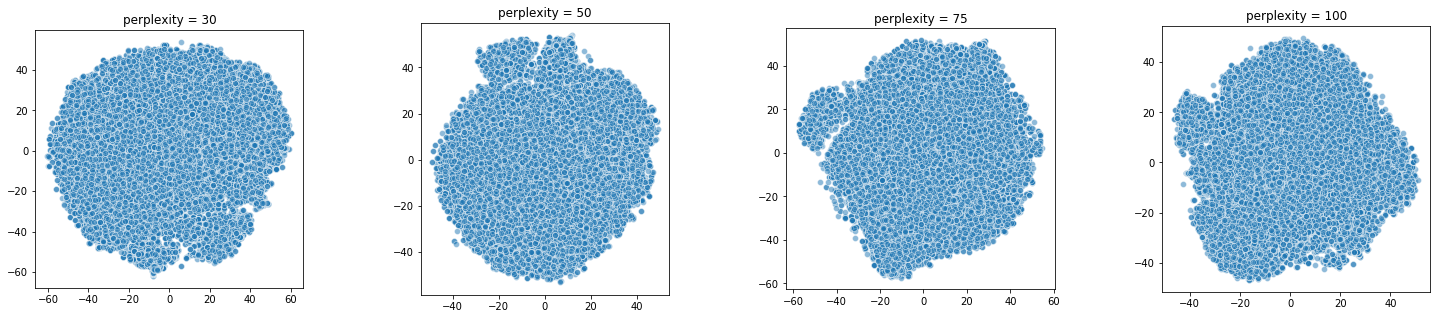

In [205]:
fig = plt.figure(figsize=(25, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.4)
index = 0
plot_index = 1
perplexities = [30, 50, 75, 100]

for i in range(len(perplexities)):
    ax = fig.add_subplot(1, len(perplexities), plot_index)
    p1,p2 = tsne_results[index][:,0], tsne_results[index][:,1]

    sns.scatterplot(p1, p2, alpha=0.5, legend=None)
    ax.set_aspect('equal')
    ax.set_title('perplexity = {}'.format(perplexities[index]))

    index += 1
    plot_index +=1

plt.savefig('tsne.png', bbox_inches='tight', dpi=600)
plt.show()

## tSNE for train and test split

In [239]:
X = df_readmitted_one_sample_per_patient.drop(['len_next_stay', 'patient_nbr', 'encounter_id'], axis=1)
Y = df_readmitted_one_sample_per_patient['len_next_stay'].values

Project the dataset to a single axis and take the top 10% of the highest values.

* Transform (normalise, one-hot encode) all features
* Project onto a single component
* Take indices with top 10% of highes tSNE component values
* Take the top 10% of the rest as validation set
* Map the points back to the points in the original dataframe

In [240]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import OneHotEncoder

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values 

class DiagEncoder(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = OneHotEncoder(*args, **kwargs, categories='auto', sparse=False, handle_unknown='ignore')
    def fit(self, X, y=0):
        X = [[self.get_type(icd_str) for icd_str in x] for x in X]
        self.encoder.fit(X)
        return self
    def transform(self, X, y=0):
        X = [[self.get_type(icd_str) for icd_str in x] for x in X]
        return self.encoder.transform(X)
    def get_type(self, icd_str):
        if isinstance(icd_str, float) and math.isnan(icd_str):
            return('missing')
        elif icd_str.isnumeric():
            icd = int(icd_str)
        elif icd_str[:3].isnumeric():
            icd = int(icd_str[:3])
        else:
            return 'other'

        if (icd >= 390 and icd <= 459 or icd == 785):
            return 'circulatory'
        elif (icd >= 520 and icd <= 579 or icd == 787):
            return 'digestive'
        elif (icd >= 580 and icd <= 629 or icd == 788):
            return 'genitourinary'
        elif (icd == 250):
            return 'diabetes'
        elif (icd >= 800 and icd <= 999):
            return 'injury'
        elif (icd >= 710 and icd <= 739):
            return 'musculoskeletal'
        elif (icd >= 140 and icd <= 239):
            return 'neoplasms'
        elif (icd >= 460 and icd <= 519 or icd == 786):
            return 'respiratory'
        else:
            return 'other'

In [25]:
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, LabelBinarizer

import math


num_features = ['time_in_hospital', 'num_lab_procedures','num_procedures', 'num_medications', 
                         'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

num_to_cat_features = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
cat_features = ['max_glu_serum', 'A1Cresult', 'readmitted', 'medical_specialty',
                'race', 'gender', 'change', 'diabetesMed', 
                'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 
                'glimepiride', 'acetohexamide', 'glipizide', 'glyburide','tolbutamide', 'pioglitazone', 'rosiglitazone', 
                'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
                'glipizide-metformin', 'glimepiride-pioglitazone','metformin-rosiglitazone', 'metformin-pioglitazone'
               ]

diag_features = ['diag_1', 'diag_2', 'diag_3']


num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_features)),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

age_pipeline = Pipeline([
    ('selector', DataFrameSelector(['age'])),
    ('ordinal_encoder', OrdinalEncoder(categories=[['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
                                                    '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']])),
    ('std_scaler', StandardScaler()),
])

diag_pipeline = Pipeline([
    ('selector', DataFrameSelector(diag_features)),
    ('diag_encoder', DiagEncoder()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_to_cat_features + cat_features)),
    ('imputer', SimpleImputer(strategy='constant')),
    ('encoder', OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore'))
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('age_pipeline', age_pipeline),
    ('diag_pipeline', diag_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [27]:
import sklearn.manifold

X_tsne = full_pipeline.fit_transform(X)

tsne = sklearn.manifold.TSNE(n_components=1, verbose=1)
X_tsne_transformed = tsne.fit_transform(X_tsne)[:,0]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16515 samples in 0.490s...
[t-SNE] Computed neighbors for 16515 samples in 102.467s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16515
[t-SNE] Computed conditional probabilities for sample 2000 / 16515
[t-SNE] Computed conditional probabilities for sample 3000 / 16515
[t-SNE] Computed conditional probabilities for sample 4000 / 16515
[t-SNE] Computed conditional probabilities for sample 5000 / 16515
[t-SNE] Computed conditional probabilities for sample 6000 / 16515
[t-SNE] Computed conditional probabilities for sample 7000 / 16515
[t-SNE] Computed conditional probabilities for sample 8000 / 16515
[t-SNE] Computed conditional probabilities for sample 9000 / 16515
[t-SNE] Computed conditional probabilities for sample 10000 / 16515
[t-SNE] Computed conditional probabilities for sample 11000 / 16515
[t-SNE] Computed conditional probabilities for sample 12000 / 16515
[t-SNE] Computed conditional probabilities for s

In [28]:
X_tsne_transformed

array([-49.89171 , -14.053665, -42.813324, ...,  12.303763, -22.843134,
        28.822744], dtype=float32)

In [29]:
test_threshold = np.quantile(X_tsne_transformed, 0.9)
dev_threshold = np.quantile(X_tsne_transformed, 0.8)

In [30]:
test_threshold

35.933656311035165

In [31]:
dev_threshold

24.03382339477539

In [32]:
test_idx = np.argwhere(X_tsne_transformed >= test_threshold).flatten()
dev_idx = np.argwhere((dev_threshold <= X_tsne_transformed) & (X_tsne_transformed < test_threshold)).flatten()
train_idx = np.argwhere(X_tsne_transformed < dev_threshold).flatten()

In [815]:
1652/16515

0.10003027550711474

In [33]:
len(test_idx)

1652

Ensure no examples leaked between train/development/test sets:

In [34]:
assert(len(np.intersect1d(train_idx, dev_idx)) == 0)
assert(len(np.intersect1d(dev_idx, test_idx)) == 0)
assert(len(np.intersect1d(train_idx, test_idx)) == 0)

In [237]:
X_train, Y_train = X.loc[train_idx], Y[train_idx]
X_dev, Y_dev = X.loc[dev_idx], Y[dev_idx]
X_test, Y_test = X.loc[test_idx], Y[test_idx]

## Feature transformation

Fit to training set, transform training/dev/test sets.

In [537]:
X = df_readmitted_one_sample_per_patient.drop(['len_next_stay', 'patient_nbr', 'encounter_id'], axis=1)
Y = df_readmitted_one_sample_per_patient['len_next_stay'].values

In [538]:
X_train, Y_train = X.loc[train_idx], Y[train_idx]
X_dev, Y_dev = X.loc[dev_idx], Y[dev_idx]
X_test, Y_test = X.loc[test_idx], Y[test_idx]

In [312]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import OneHotEncoder

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values 

class DiagEncoder(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = OneHotEncoder(*args, **kwargs, categories='auto', sparse=False, handle_unknown='ignore')
    def fit(self, X, y=0):
        X = [[self.get_type(icd_str) for icd_str in x] for x in X]
        self.encoder.fit(X)
        return self
    def transform(self, X, y=0):
        X = [[self.get_type(icd_str) for icd_str in x] for x in X]
        return self.encoder.transform(X)
    def get_type(self, icd_str):
        if isinstance(icd_str, float) and math.isnan(icd_str):
            return('missing')
        elif icd_str.isnumeric():
            icd = int(icd_str)
        elif icd_str[:3].isnumeric():
            icd = int(icd_str[:3])
        else:
            return 'other'

        if (icd >= 390 and icd <= 459 or icd == 785):
            return 'circulatory'
        elif (icd >= 520 and icd <= 579 or icd == 787):
            return 'digestive'
        elif (icd >= 580 and icd <= 629 or icd == 788):
            return 'genitourinary'
        elif (icd == 250):
            return 'diabetes'
        elif (icd >= 800 and icd <= 999):
            return 'injury'
        elif (icd >= 710 and icd <= 739):
            return 'musculoskeletal'
        elif (icd >= 140 and icd <= 239):
            return 'neoplasms'
        elif (icd >= 460 and icd <= 519 or icd == 786):
            return 'respiratory'
        else:
            return 'other'

In [580]:
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, Normalizer, LabelBinarizer

import math


num_features = ['time_in_hospital', 'num_lab_procedures','num_procedures', 'num_medications', 
                         'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

num_to_cat_features = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
cat_features = ['max_glu_serum', 'A1Cresult', 'readmitted', 
                'race', 'gender', 'change', 'diabetesMed', 
               'medical_specialty',
                'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 
                'glimepiride', 'acetohexamide', 'glipizide', 'glyburide','tolbutamide', 'pioglitazone', 'rosiglitazone', 
                'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
                'glipizide-metformin', 'glimepiride-pioglitazone','metformin-rosiglitazone', 'metformin-pioglitazone'
               ]

diag_features = ['diag_1', 'diag_2', 'diag_3']


num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_features)),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
    ('normalizer', Normalizer()),
])

age_pipeline = Pipeline([
    ('selector', DataFrameSelector(['age'])),
    ('ordinal_encoder', OrdinalEncoder(categories=[['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
                                                    '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']])),
    ('std_scaler', StandardScaler()),
    ('normalizer', Normalizer()),
])

diag_pipeline = Pipeline([
    ('selector', DataFrameSelector(diag_features)),
    ('diag_encoder', DiagEncoder()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_to_cat_features + cat_features)),
    ('imputer', SimpleImputer(strategy='constant')),
    ('encoder', OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore'))
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('age_pipeline', age_pipeline),
    ('diag_pipeline', diag_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [539]:
X_train = full_pipeline.fit_transform(X_train)
X_dev = full_pipeline.transform(X_dev)
X_test = full_pipeline.transform(X_test)

In [540]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212
0,0.280146,0.444268,0.653216,0.515567,-0.081051,-0.066709,-0.126930,0.067177,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
1,0.684153,0.219835,0.123557,0.127532,-0.124120,-0.102157,0.571021,0.316496,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
2,-0.417122,0.071632,0.702218,-0.182911,-0.111581,-0.091837,0.513337,-0.099561,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
3,0.461280,0.250083,0.319333,0.072473,-0.070534,-0.058053,0.759448,0.179856,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [541]:
Y_train = Y_train.astype(np.float32)
Y_dev = Y_dev.astype(np.float32)
Y_test = Y_test.astype(np.float32)

In [354]:
X_train.shape

(13211, 99)

In [390]:
assert not np.any(np.isnan(X_train))

## Neural networks

In [391]:
import tensorflow as tf

### Loss function

In [250]:
from tensorflow.keras import backend as K

def ztp_log_loss_inexact(y_true, y_pred):
    return K.mean(-y_true * K.log(y_pred + K.epsilon()) + K.log(K.exp(y_pred) - 1 + K.epsilon()))

# Stirling's approximation https://www.tensorflow.org/api_docs/python/tf/nn/log_poisson_loss
def ztp_log_loss_full(y_true, y_pred):
    return K.mean(-y_true * K.log(y_pred + K.epsilon()) 
                  + K.log(K.exp(y_pred) - 1 + K.epsilon()) 
                  + y_true * K.log(y_true + K.epsilon()) - y_true + 0.5 * K.log(2 * math.pi * y_true + K.epsilon()))

### Training

In [ ]:
# Set up an endless iteration through epochs and batches of data
BATCH_SIZE = 20
indexes = np.arange(len(X_train))
indexes = np.array_split(indexes, len(X_train) / BATCH_SIZE)
eb_indexes = enumerate_cycle(indexes)

# Accumulate some stats as we go along
loss_history = []

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=X_train.shape[1], input_shape=(X_train.shape[1],), kernel_initializer='random_uniform'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=256, kernel_initializer='random_uniform'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=128, kernel_initializer='random_uniform'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=32, kernel_initializer='random_uniform'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=1, kernel_initializer='random_uniform')
])

model.compile(loss = ztp_log_loss_full,
              metrics = ['mse'],
              optimizer = keras.optimizers.Adam())

from datetime import datetime 

while not interrupted():
    start_time = datetime.now()
    (epoch,batch),i = next(eb_indexes)
    loss = model.train_on_batch(X_train[i], Y_train[i])
    time_elapsed = (datetime.now() - start_time).microseconds / 1000.0
    if batch % 100 == 0:
        IPython.display.clear_output(wait=True)
        print(f'loss={loss} epoch={epoch} batchnum={batch}/{len(indexes)} time={time_elapsed} ms')
        loss_history.append((epoch+batch/len(indexes), 
                             loss[0], loss[1], 
                             ztp_log_loss_full(Y_dev, model.predict(X_dev)),
                             time_elapsed))

Alternatively, train on fixed number of epochs:

In [446]:
# Set up an endless iteration through epochs and batches of data
BATCH_SIZE = 10
indexes = np.arange(len(X_train))
indexes = np.array_split(indexes, len(X_train) / BATCH_SIZE)
eb_indexes = enumerate_cycle(indexes)

# Accumulate some stats as we go along
loss_history = []

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=X_train.shape[1], input_shape=(X_train.shape[1],), kernel_initializer='random_uniform'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=256, kernel_initializer='random_uniform'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=256, kernel_initializer='random_uniform'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=128, kernel_initializer='random_uniform'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=64, kernel_initializer='random_uniform'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=32, kernel_initializer='random_uniform'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=1, kernel_initializer='random_uniform')
])

model.compile(loss = ztp_log_loss_full,
              metrics = ['mse', 'poisson'],
              optimizer = keras.optimizers.Adam())

epoch = 0
while epoch < 5:
    start_time = datetime.now()
    (epoch,batch),i = next(eb_indexes)
    loss = model.train_on_batch(X_train[i], Y_train[i])
    time_elapsed = (datetime.now() - start_time).microseconds / 1000.0
    if batch % 100 == 0:
        IPython.display.clear_output(wait=True)
        print(f'loss={loss} epoch={epoch} batchnum={batch}/{len(indexes)} time={time_elapsed} ms')
        loss_history.append((epoch+batch/len(indexes), 
                             loss[0], loss[1], 
                             ztp_log_loss_full(Y_dev, model.predict(X_dev)),
                             time_elapsed))

loss=[2.1181705, 4.5534286, -3.5034952] epoch=5 batchnum=0/1321 time=2.223 ms


In [721]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=X_train.shape[1], input_shape=(X_train.shape[1],)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=1024),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=1024),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=256),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=128),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=32),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Activation('relu'),
])

model.compile(loss = ztp_log_loss_full,
              metrics = ['mse', 'poisson'],
              optimizer = keras.optimizers.Adam())

In [ ]:
from datetime import datetime 

loss_history = []
time_history = []

for epoch in range(10):
    start_time = datetime.now()
    for i in range(0,len(X_train), BATCH_SIZE):
        input_batch = X_train[i:i+BATCH_SIZE]
        output_batch = Y_train[i:i+BATCH_SIZE]
        loss = model.train_on_batch(input_batch, output_batch)
        loss_history.append((epoch+i/(len(X_train)/BATCH_SIZE), 
                             loss[0], loss[1], 
                             ztp_log_loss_full(Y_dev, model.predict(X_dev))))
    time_elapsed = (datetime.now() - start_time).seconds
    time_history.append(time_elapsed)
    print(f'loss={loss} epoch={epoch} time={time_elapsed} s')

Final training loss: 1.938858095132968


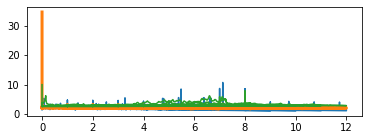

In [506]:
# Simple plot of the training loss
df = pd.DataFrame.from_records(loss_history, columns=['epoch','loss', 'mse', 'dev'])
print("Final training loss:", df.loss.ewm(com=5).mean().iloc[-1])
fig,ax = plt.subplots(figsize=(6,2))
ax.plot(df.epoch, df.loss)
ax.plot(df.epoch, df.loss.ewm(com=5).mean(), linewidth=3)
# ax.plot(df.epoch, df.mse)
ax.plot(df.epoch, df.dev)
# ax.set_ylim([0, 10])
plt.show()

In [560]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.val_loss = []

    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))

In [722]:
from datetime import datetime
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
ton = tf.keras.callbacks.TerminateOnNaN()
history = LossHistory()
start_time = datetime.now()
result = model.fit(X_train, Y_train, 
                   epochs=100, batch_size=20, 
                   validation_data=(X_dev, Y_dev), 
                   callbacks=[es, ton, history],
                   verbose=2)
total_time = datetime.now() - start_time
print('Total time: {}'.format(total_time.seconds))

Train on 13211 samples, validate on 1652 samples
Epoch 1/100
13211/13211 - 8s - loss: 2.5759 - mse: 9.8702 - poisson: -2.4287e+00 - val_loss: 2.4635 - val_mse: 9.0528 - val_poisson: -2.2803e+00
Epoch 2/100
13211/13211 - 9s - loss: 2.4777 - mse: 9.1482 - poisson: -2.5331e+00 - val_loss: 2.6539 - val_mse: 11.0732 - val_poisson: -2.1062e+00
Epoch 3/100
13211/13211 - 8s - loss: 2.4616 - mse: 8.9982 - poisson: -2.5492e+00 - val_loss: 2.4718 - val_mse: 9.0861 - val_poisson: -2.2827e+00
Epoch 4/100
13211/13211 - 8s - loss: 2.4521 - mse: 8.8991 - poisson: -2.5578e+00 - val_loss: 2.4735 - val_mse: 9.1141 - val_poisson: -2.2807e+00
Epoch 5/100
13211/13211 - 8s - loss: 2.4339 - mse: 8.7467 - poisson: -2.5756e+00 - val_loss: 2.4428 - val_mse: 8.8232 - val_poisson: -2.3090e+00
Epoch 6/100
13211/13211 - 9s - loss: 2.3989 - mse: 8.4269 - poisson: -2.6097e+00 - val_loss: 2.4603 - val_mse: 9.0079 - val_poisson: -2.2923e+00
Epoch 7/100
13211/13211 - 8s - loss: 2.3767 - mse: 8.1651 - poisson: -2.6306e+00

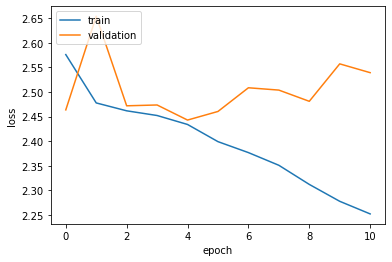

In [725]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

(0.6938827236233398, 0.0)


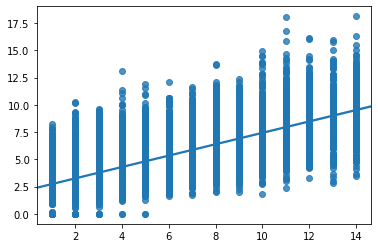

In [699]:
import scipy
print(scipy.stats.pearsonr(Y_train, model.predict(X_train).flatten()))
sns.regplot(x=Y_train, y=model.predict(X_train).flatten())

(0.12355880141964953, 4.715631950841789e-07)


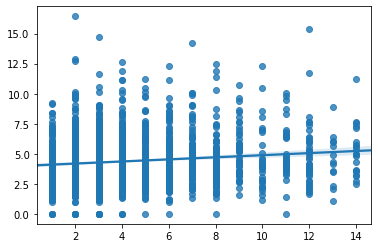

In [700]:
print(scipy.stats.pearsonr(Y_dev, model.predict(X_dev).flatten()))
sns.regplot(x=Y_dev, y=model.predict(X_dev).flatten())

## PCA

In [589]:
X = df_readmitted_one_sample_per_patient.drop(['len_next_stay', 'patient_nbr', 'encounter_id'], axis=1)
Y = df_readmitted_one_sample_per_patient['len_next_stay'].values

In [590]:
X_train, Y_train = X.loc[train_idx], Y[train_idx]
X_dev, Y_dev = X.loc[dev_idx], Y[dev_idx]
X_test, Y_test = X.loc[test_idx], Y[test_idx]

X_train = full_pipeline.fit_transform(X_train)
X_dev = full_pipeline.transform(X_dev)
X_test = full_pipeline.transform(X_test)

Y_train = Y_train.astype(np.float32)
Y_dev = Y_dev.astype(np.float32)
Y_test = Y_test.astype(np.float32)

In [591]:
pca = sklearn.decomposition.PCA()
X_train_PCA = pca.fit_transform(X_train)
X_dev_PCA = pca.transform(X_dev)

In [592]:
X_train_PCA.shape

(13211, 213)

In [593]:
X_dev_PCA.dtype

dtype('float64')

In [ ]:
# Accumulate some stats as we go along
loss_history_PCA = []
time_history_PCA = []

model_PCA = tf.keras.Sequential([
    tf.keras.layers.Dense(units=X_train_PCA.shape[1], input_shape=(X_train_PCA.shape[1],), kernel_initializer='random_uniform'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=256, kernel_initializer='random_uniform'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=128, kernel_initializer='random_uniform'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=64, kernel_initializer='random_uniform'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=1, kernel_initializer='random_uniform')
])

model_PCA.compile(loss = ztp_log_loss_full,
              metrics = ['mse', 'poisson'],
              optimizer = keras.optimizers.Adam())

from datetime import datetime 

for epoch in range(10):
    start_time = datetime.now()
    for i in range(0,len(X_train_PCA), BATCH_SIZE):
        input_batch = X_train_PCA[i:i+BATCH_SIZE]
        output_batch = Y_train[i:i+BATCH_SIZE]
        loss = model_PCA.train_on_batch(input_batch, output_batch)
        loss_history_PCA.append((epoch+batch/len(X_train_PCA), 
                             loss[0], loss[1], 
                             ztp_log_loss_full(Y_dev, model_PCA.predict(X_dev_PCA))))
    time_elapsed = (datetime.now() - start_time).seconds
    time_history_PCA.append(time_elapsed)
    print(f'loss={loss} epoch={epoch} time={time_elapsed} ms')

Final training loss: 2.4350769643491024


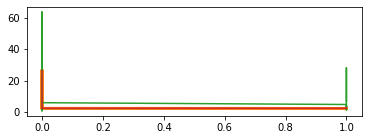

In [479]:
# Simple plot of the training loss
df = pd.DataFrame.from_records(loss_history_PCA, columns=['epoch','loss', 'mse', 'dev'])
print("Final training loss:", df.loss.ewm(com=5).mean().iloc[-1])
fig,ax = plt.subplots(figsize=(6,2))
ax.plot(df.epoch, df.loss)
ax.plot(df.epoch, df.loss.ewm(com=5).mean(), linewidth=3)
ax.plot(df.epoch, df.mse)
ax.plot(df.epoch, df.dev.apply(lambda x: x.numpy()))
plt.show()

In [715]:
model_PCA = tf.keras.Sequential([
    tf.keras.layers.Dense(units=X_train_PCA.shape[1], input_shape=(X_train_PCA.shape[1],)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=1024),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=1024),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=256),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=128),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=32),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Activation('relu'),
])

model_PCA.compile(loss = ztp_log_loss_full,
              metrics = ['mse', 'poisson'],
              optimizer = keras.optimizers.Adam())

In [723]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
ton = tf.keras.callbacks.TerminateOnNaN()
# history_PCA = LossHistory()
start_time = datetime.now()
result_PCA = model_PCA.fit(X_train_PCA, Y_train, 
                   epochs=100, batch_size=20, 
                   validation_data=(X_dev_PCA, Y_dev), 
                   callbacks=[es, ton],
                   verbose=2)
total_time = datetime.now() - start_time
print('Total time: {}'.format(total_time.seconds))

Train on 13211 samples, validate on 1652 samples
Epoch 1/100
13211/13211 - 8s - loss: 1.9391 - mse: 4.1470 - poisson: -2.9576e+00 - val_loss: 2.8768 - val_mse: 12.8449 - val_poisson: -1.8134e+00
Epoch 2/100
13211/13211 - 8s - loss: 1.8578 - mse: 3.3376 - poisson: -2.9113e+00 - val_loss: 2.8414 - val_mse: 14.2701 - val_poisson: -1.8938e+00
Epoch 3/100
13211/13211 - 8s - loss: 1.7957 - mse: 2.9674 - poisson: -3.0494e+00 - val_loss: 2.7800 - val_mse: 11.9246 - val_poisson: -1.9256e+00
Epoch 4/100
13211/13211 - 9s - loss: 1.7459 - mse: 2.4807 - poisson: -2.9758e+00 - val_loss: 3.1708 - val_mse: 13.6458 - val_poisson: -1.3594e+00
Epoch 5/100
13211/13211 - 9s - loss: 1.7002 - mse: 2.1264 - poisson: -2.9257e+00 - val_loss: 3.2377 - val_mse: 12.9046 - val_poisson: -1.3414e+00
Epoch 6/100
13211/13211 - 9s - loss: 1.6914 - mse: 2.0434 - poisson: -2.6929e+00 - val_loss: 3.1485 - val_mse: 13.1351 - val_poisson: -1.4516e+00
Epoch 7/100
13211/13211 - 8s - loss: 1.6627 - mse: 1.8961 - poisson: -2.864

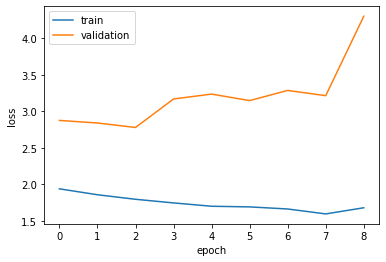

In [726]:
plt.plot(result_PCA.history['loss'])
plt.plot(result_PCA.history['val_loss'])
# plt.plot(history.loss)
# plt.plot(history.val_loss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

(0.9385632457839167, 0.0)


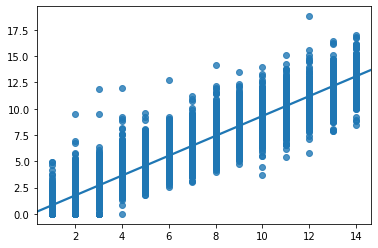

In [727]:
import scipy
print(scipy.stats.pearsonr(Y_train, model_PCA.predict(X_train_PCA).flatten()))
sns.regplot(x=Y_train, y=model_PCA.predict(X_train_PCA).flatten())

(0.1297074659622367, 1.2211167523335807e-07)


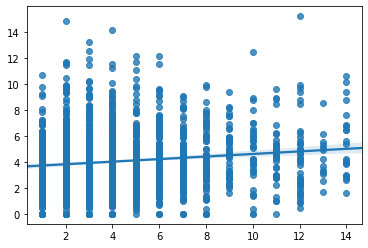

In [728]:
print(scipy.stats.pearsonr(Y_dev, model_PCA.predict(X_dev_PCA).flatten()))
sns.regplot(x=Y_dev, y=model_PCA.predict(X_dev_PCA).flatten())

## PCA on less components

In [732]:
X_train_PCA_reduced = X_train_PCA[:, :X_train_PCA.shape[1]//2]
X_dev_PCA_reduced = X_dev_PCA[:, :X_dev_PCA.shape[1]//2]

In [735]:
model_PCA_reduced = tf.keras.Sequential([
    tf.keras.layers.Dense(units=X_train_PCA_reduced.shape[1], input_shape=(X_train_PCA_reduced.shape[1],)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=1024),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=1024),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=256),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=128),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=32),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Activation('relu'),
])

model_PCA_reduced.compile(loss = ztp_log_loss_full,
              metrics = ['mse', 'poisson'],
              optimizer = keras.optimizers.Adam())

In [742]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
ton = tf.keras.callbacks.TerminateOnNaN()
# history_PCA = LossHistory()
start_time = datetime.now()
result_PCA_reduced = model_PCA_reduced.fit(X_train_PCA_reduced, Y_train, 
                   epochs=100, batch_size=20, 
                   validation_data=(X_dev_PCA_reduced, Y_dev), 
                   callbacks=[es, ton],
                   verbose=2)
total_time = datetime.now() - start_time
print('Total time: {}'.format(total_time.seconds))

Train on 13211 samples, validate on 1652 samples
Epoch 1/100
13211/13211 - 8s - loss: 2.1669 - mse: 6.2978 - poisson: -2.8216e+00 - val_loss: 2.6264 - val_mse: 10.5691 - val_poisson: -2.1018e+00
Epoch 2/100
13211/13211 - 8s - loss: 2.0687 - mse: 5.3581 - poisson: -2.9090e+00 - val_loss: 2.7685 - val_mse: 13.3716 - val_poisson: -1.9782e+00
Epoch 3/100
13211/13211 - 8s - loss: 1.9835 - mse: 4.5963 - poisson: -2.9820e+00 - val_loss: 2.7697 - val_mse: 12.0794 - val_poisson: -1.9508e+00
Epoch 4/100
13211/13211 - 8s - loss: 1.8950 - mse: 3.8365 - poisson: -3.0544e+00 - val_loss: 2.8243 - val_mse: 12.2441 - val_poisson: -1.8824e+00
Epoch 5/100
13211/13211 - 8s - loss: 1.8813 - mse: 3.4212 - poisson: -2.9069e+00 - val_loss: 3.0331 - val_mse: 14.3580 - val_poisson: -1.6248e+00
Epoch 6/100
13211/13211 - 8s - loss: 1.8444 - mse: 3.0312 - poisson: -2.7940e+00 - val_loss: 3.2616 - val_mse: 12.9680 - val_poisson: -1.3289e+00
Epoch 7/100
13211/13211 - 8s - loss: 1.7412 - mse: 2.4516 - poisson: -2.956

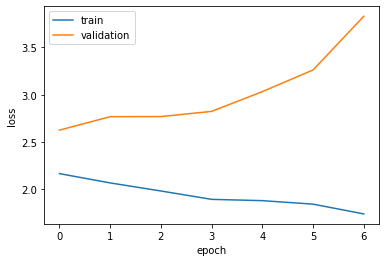

In [743]:
plt.plot(result_PCA_reduced.history['loss'])
plt.plot(result_PCA_reduced.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

(0.9077306057804271, 0.0)


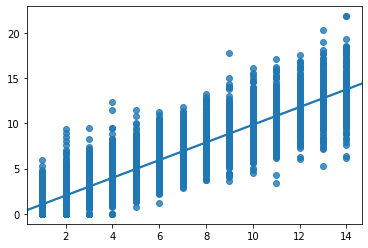

In [744]:
import scipy
print(scipy.stats.pearsonr(Y_train, model_PCA_reduced.predict(X_train_PCA_reduced).flatten()))
sns.regplot(x=Y_train, y=model_PCA_reduced.predict(X_train_PCA_reduced).flatten())

(0.09404631587524322, 0.00012914280205488277)


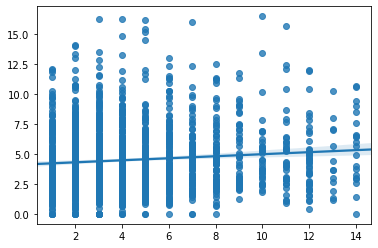

In [745]:
print(scipy.stats.pearsonr(Y_dev, model_PCA_reduced.predict(X_dev_PCA_reduced).flatten()))
sns.regplot(x=Y_dev, y=model_PCA_reduced.predict(X_dev_PCA_reduced).flatten())

# Typical moderate model performance (3M parameters)

In [751]:
full_histories = []
pca_histories = []
pca_reduced_histories = []

full_times = []
pca_times = []
pca_reduced_times = []

full_train_correlations = []
pca_train_correlations = []
pca_reduced_train_correlations = []

full_dev_correlations = []
pca_dev_correlations = []
pca_reduced_dev_correlations = []


for trial in range(5):
    print('TRIAL {}'.format(trial))
    # FULL
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=X_train.shape[1], input_shape=(X_train.shape[1],)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=256),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=128),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=64),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=32),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1),
        tf.keras.layers.Activation('relu'),
    ])
    
    model.compile(loss = ztp_log_loss_full,
              metrics = ['mse', 'poisson'],
              optimizer = keras.optimizers.Adam())
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    ton = tf.keras.callbacks.TerminateOnNaN()
    start_time = datetime.now()
    result = model.fit(X_train, Y_train, 
                       epochs=100, batch_size=20, 
                       validation_data=(X_dev, Y_dev), 
                       callbacks=[es, ton],
                       verbose=2)
    total_time = datetime.now() - start_time
    print('Total time: {}'.format(total_time.seconds))
    
    full_histories.append(result)
    full_times.append(total_time)
    full_train_correlations.append(scipy.stats.pearsonr(Y_train, model.predict(X_train).flatten()))
    full_dev_correlations.append(scipy.stats.pearsonr(Y_dev, model.predict(X_dev).flatten()))
    
    del model
    
    # PCA
    
    model_PCA = tf.keras.Sequential([
        tf.keras.layers.Dense(units=X_train_PCA.shape[1], input_shape=(X_train_PCA.shape[1],)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=256),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=128),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=64),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=32),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1),
        tf.keras.layers.Activation('relu'),
    ])
    model_PCA.compile(loss = ztp_log_loss_full,
          metrics = ['mse', 'poisson'],
          optimizer = keras.optimizers.Adam())
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    ton = tf.keras.callbacks.TerminateOnNaN()
    start_time = datetime.now()
    result_PCA = model_PCA.fit(X_train_PCA, Y_train, 
                       epochs=100, batch_size=20, 
                       validation_data=(X_dev_PCA, Y_dev), 
                       callbacks=[es, ton],
                       verbose=2)
    total_time = datetime.now() - start_time
    print('Total time: {}'.format(total_time.seconds))
    
    pca_histories.append(result_PCA)
    pca_times.append(total_time)
    pca_train_correlations.append(scipy.stats.pearsonr(Y_train, model_PCA.predict(X_train_PCA).flatten()))
    pca_dev_correlations.append(scipy.stats.pearsonr(Y_dev, model_PCA.predict(X_dev_PCA).flatten()))
    
    del model_PCA
    
    
    # REDUCED PCA
    model_PCA_reduced = tf.keras.Sequential([
        tf.keras.layers.Dense(units=X_train_PCA_reduced.shape[1], input_shape=(X_train_PCA_reduced.shape[1],)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=256),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=128),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=64),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=32),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1),
        tf.keras.layers.Activation('relu'),
    ])
    model_PCA_reduced.compile(loss = ztp_log_loss_full,
          metrics = ['mse', 'poisson'],
          optimizer = keras.optimizers.Adam())
    
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    ton = tf.keras.callbacks.TerminateOnNaN()
    start_time = datetime.now()
    result_PCA_reduced = model_PCA_reduced.fit(X_train_PCA_reduced, Y_train, 
                       epochs=100, batch_size=20, 
                       validation_data=(X_dev_PCA_reduced, Y_dev), 
                       callbacks=[es, ton],
                       verbose=2)
    total_time = datetime.now() - start_time
    print('Total time: {}'.format(total_time.seconds))
    
    pca_reduced_histories.append(result_PCA_reduced)
    pca_reduced_times.append(total_time)
    pca_reduced_train_correlations.append(scipy.stats.pearsonr(Y_train, model_PCA_reduced.predict(X_train_PCA_reduced).flatten()))
    pca_reduced_dev_correlations.append(scipy.stats.pearsonr(Y_dev, model_PCA_reduced.predict(X_dev_PCA_reduced).flatten()))
    
    del model_PCA_reduced

TRIAL 0
Train on 13211 samples, validate on 1652 samples
Epoch 1/100
13211/13211 - 8s - loss: 2.5660 - mse: 9.8063 - poisson: -2.4396e+00 - val_loss: 2.4569 - val_mse: 8.9943 - val_poisson: -2.2868e+00
Epoch 2/100
13211/13211 - 8s - loss: 2.4735 - mse: 9.1037 - poisson: -2.5375e+00 - val_loss: 2.7072 - val_mse: 11.7180 - val_poisson: -2.0535e+00
Epoch 3/100
13211/13211 - 8s - loss: 2.4613 - mse: 8.9886 - poisson: -2.5494e+00 - val_loss: 2.4682 - val_mse: 9.0346 - val_poisson: -2.2865e+00
Epoch 4/100
13211/13211 - 8s - loss: 2.4517 - mse: 8.8932 - poisson: -2.5582e+00 - val_loss: 2.4625 - val_mse: 9.0313 - val_poisson: -2.2898e+00
Epoch 5/100
13211/13211 - 8s - loss: 2.4312 - mse: 8.7162 - poisson: -2.5785e+00 - val_loss: 2.4384 - val_mse: 8.7623 - val_poisson: -2.3131e+00
Epoch 6/100
13211/13211 - 8s - loss: 2.3944 - mse: 8.3888 - poisson: -2.6140e+00 - val_loss: 2.4811 - val_mse: 9.2186 - val_poisson: -2.2719e+00
Epoch 7/100
13211/13211 - 8s - loss: 2.3670 - mse: 8.0869 - poisson: -2.

/Users/kamilestankeviciute/anaconda3/envs/datasci/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Train on 13211 samples, validate on 1652 samples
Epoch 1/100
13211/13211 - 9s - loss: 2.6561 - mse: 9.8998 - poisson: -2.3276e+00 - val_loss: 2.4577 - val_mse: 8.9721 - val_poisson: -2.2905e+00
Epoch 2/100
13211/13211 - 8s - loss: 2.4626 - mse: 9.0275 - poisson: -2.5471e+00 - val_loss: 2.8221 - val_mse: 13.4082 - val_poisson: -1.9387e+00
Epoch 3/100
13211/13211 - 8s - loss: 2.4326 - mse: 8.7508 - poisson: -2.5765e+00 - val_loss: 2.4534 - val_mse: 8.9471 - val_poisson: -2.2946e+00
Epoch 4/100
13211/13211 - 8s - loss: 2.4009 - mse: 8.4490 - poisson: -2.6069e+00 - val_loss: 2.4629 - val_mse: 9.0857 - val_poisson: -2.2846e+00
Epoch 5/100
13211/13211 - 8s - loss: 2.3590 - mse: 8.0785 - poisson: -2.6467e+00 - val_loss: 2.4895 - val_mse: 9.3770 - val_poisson: -2.2571e+00
Epoch 6/100
13211/13211 - 8s - loss: 2.2964 - mse: 7.5147 - poisson: -2.7046e+00 - val_loss: 2.5023 - val_mse: 9.4658 - val_poisson: -2.2427e+00
Epoch 7/100
13211/13211 - 8s - loss: 2.2233 - mse: 6.7939 - poisson: -2.7717e+00

In [752]:
print(np.mean(full_times), np.mean(pca_times[1:]), np.mean(pca_reduced_times))

0:01:08.966426 0:01:01.400467 0:01:04.504523


In [757]:
print(np.mean([x for x, _ in full_train_correlations]),
np.mean([x for x, _ in pca_train_correlations[1:]]),
np.mean([x for x, _ in pca_reduced_train_correlations]))

0.5433088761142086 0.7238644760326629 0.731322930049501


In [758]:
print(np.mean([x for x, _ in full_dev_correlations]),
np.mean([x for x, _ in pca_dev_correlations[1:]]),
np.mean([x for x, _ in pca_reduced_dev_correlations]))

0.17923319054019318 0.13985328281171056 0.14271374568348982


In [761]:
print(np.mean([trial.history['loss'][-1] for trial in full_histories]),
      np.mean([trial.history['loss'][-1] for trial in pca_histories[1:]]),
      np.mean([trial.history['loss'][-1] for trial in pca_reduced_histories]))

2.3114184834650144 2.145401650629292 2.152004119119261


In [762]:
print(np.mean([trial.history['val_loss'][-1] for trial in full_histories]),
      np.mean([trial.history['val_loss'][-1] for trial in pca_histories[1:]]),
      np.mean([trial.history['val_loss'][-1] for trial in pca_reduced_histories]))

2.5228859500215357 2.6711122374124736 2.646059370329536


# Crazy deep model (6M parameters)

In [784]:
model_crazy_deep = tf.keras.Sequential([
    tf.keras.layers.Dense(units=X_train.shape[1], input_shape=(X_train.shape[1],)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=1024),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=1024),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=1024),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=1024),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=1024),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=256),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=128),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=32),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Activation('relu'),
])

model_crazy_deep.compile(loss = ztp_log_loss_full,
              metrics = ['mse', 'poisson'],
              optimizer = keras.optimizers.Adam())

In [785]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
ton = tf.keras.callbacks.TerminateOnNaN()
# history_PCA = LossHistory()
start_time = datetime.now()
r = model_crazy_deep.fit(X_train, Y_train, 
                   epochs=100, batch_size=20, 
                   validation_data=(X_dev, Y_dev), 
                   callbacks=[es, ton],
                   verbose=2)
total_time = datetime.now() - start_time
print('Total time: {}'.format(total_time.seconds))

Train on 13211 samples, validate on 1652 samples
Epoch 1/100
13211/13211 - 17s - loss: 3.6589 - mse: 10.6625 - poisson: -1.0733e+00 - val_loss: 2.4708 - val_mse: 9.1430 - val_poisson: -2.2696e+00
Epoch 2/100
13211/13211 - 16s - loss: 2.5089 - mse: 9.4578 - poisson: -2.4999e+00 - val_loss: 2.4378 - val_mse: 8.7837 - val_poisson: -2.3120e+00
Epoch 3/100
13211/13211 - 16s - loss: 2.4932 - mse: 9.3080 - poisson: -2.5149e+00 - val_loss: 2.4890 - val_mse: 9.2969 - val_poisson: -2.2662e+00
Epoch 4/100
13211/13211 - 16s - loss: 2.4792 - mse: 9.1863 - poisson: -2.5279e+00 - val_loss: 2.4693 - val_mse: 9.0946 - val_poisson: -2.2821e+00
Epoch 5/100
13211/13211 - 17s - loss: 2.4421 - mse: 8.8530 - poisson: -2.5654e+00 - val_loss: 2.4975 - val_mse: 9.3656 - val_poisson: -2.2366e+00
Epoch 6/100
13211/13211 - 17s - loss: 2.4175 - mse: 8.6434 - poisson: -2.5889e+00 - val_loss: 2.4549 - val_mse: 8.9647 - val_poisson: -2.2963e+00
Epoch 7/100
13211/13211 - 16s - loss: 2.3785 - mse: 8.2082 - poisson: -2.6

(0.6367506856663616, 0.0)


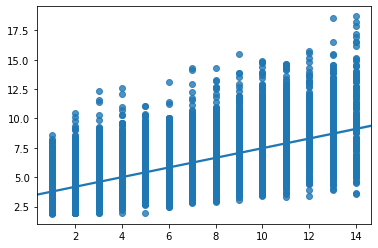

In [786]:
import scipy
print(scipy.stats.pearsonr(Y_train, model_crazy_deep.predict(X_train).flatten()))
sns.regplot(x=Y_train, y=model_crazy_deep.predict(X_train).flatten())

(0.14554835267926092, 2.7988809515980117e-09)


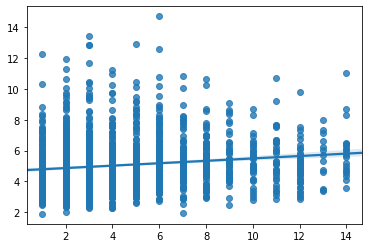

In [787]:
print(scipy.stats.pearsonr(Y_dev, model_crazy_deep.predict(X_dev).flatten()))
sns.regplot(x=Y_dev, y=model_crazy_deep.predict(X_dev).flatten())

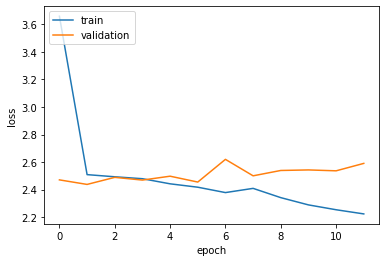

In [789]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Shallow model (250K parameters)

In [795]:
model_shallow = tf.keras.Sequential([
    tf.keras.layers.Dense(units=X_train.shape[1], input_shape=(X_train.shape[1],)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=256),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=128),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=32),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Activation('relu'),
])

model_shallow.compile(loss = ztp_log_loss_full,
              metrics = ['mse', 'poisson'],
              optimizer = keras.optimizers.Adam())

In [796]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
ton = tf.keras.callbacks.TerminateOnNaN()
# history_PCA = LossHistory()
start_time = datetime.now()
r = model_shallow.fit(X_train, Y_train, 
                   epochs=100, batch_size=20, 
                   validation_data=(X_dev, Y_dev), 
                   callbacks=[es, ton],
                   verbose=2)
total_time = datetime.now() - start_time
print('Total time: {}'.format(total_time.seconds))

Train on 13211 samples, validate on 1652 samples
Epoch 1/100
13211/13211 - 2s - loss: 3.3243 - mse: 9.7947 - poisson: -1.4851e+00 - val_loss: 2.4475 - val_mse: 8.8554 - val_poisson: -2.3039e+00
Epoch 2/100
13211/13211 - 1s - loss: 2.4609 - mse: 8.9897 - poisson: -2.5516e+00 - val_loss: 2.6066 - val_mse: 10.5156 - val_poisson: -2.1528e+00
Epoch 3/100
13211/13211 - 1s - loss: 2.4561 - mse: 8.9382 - poisson: -2.5556e+00 - val_loss: 2.4350 - val_mse: 8.7808 - val_poisson: -2.3124e+00
Epoch 4/100
13211/13211 - 1s - loss: 2.4362 - mse: 8.7443 - poisson: -2.5752e+00 - val_loss: 2.4456 - val_mse: 8.8537 - val_poisson: -2.3052e+00
Epoch 5/100
13211/13211 - 1s - loss: 2.4198 - mse: 8.5873 - poisson: -2.5910e+00 - val_loss: 2.4387 - val_mse: 8.7862 - val_poisson: -2.3124e+00
Epoch 6/100
13211/13211 - 1s - loss: 2.3968 - mse: 8.3955 - poisson: -2.6122e+00 - val_loss: 2.4367 - val_mse: 8.7984 - val_poisson: -2.3096e+00
Epoch 7/100
13211/13211 - 1s - loss: 2.3706 - mse: 8.1123 - poisson: -2.6372e+00

(0.6563443951821919, 0.0)


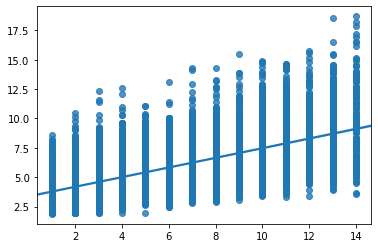

In [797]:
import scipy
print(scipy.stats.pearsonr(Y_train, model_shallow.predict(X_train).flatten()))
sns.regplot(x=Y_train, y=model_crazy_deep.predict(X_train).flatten())

(0.15206778935441434, 5.223189770289478e-10)


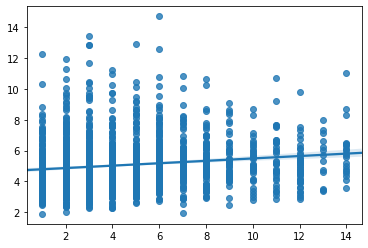

In [798]:
print(scipy.stats.pearsonr(Y_dev, model_shallow.predict(X_dev).flatten()))
sns.regplot(x=Y_dev, y=model_crazy_deep.predict(X_dev).flatten())

# Typical shallow network performance (250K parameters)

In [799]:
sfull_histories = []
spca_histories = []
spca_reduced_histories = []

sfull_times = []
spca_times = []
spca_reduced_times = []

sfull_train_correlations = []
spca_train_correlations = []
spca_reduced_train_correlations = []

sfull_dev_correlations = []
spca_dev_correlations = []
spca_reduced_dev_correlations = []


for trial in range(5):
    print('TRIAL {}'.format(trial))
    # FULL
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=X_train.shape[1], input_shape=(X_train.shape[1],)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=256),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=128),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=64),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=32),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1),
        tf.keras.layers.Activation('relu'),
    ])
    
    model.compile(loss = ztp_log_loss_full,
              metrics = ['mse', 'poisson'],
              optimizer = keras.optimizers.Adam())
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    ton = tf.keras.callbacks.TerminateOnNaN()
    start_time = datetime.now()
    result = model.fit(X_train, Y_train, 
                       epochs=100, batch_size=20, 
                       validation_data=(X_dev, Y_dev), 
                       callbacks=[es, ton],
                       verbose=2)
    total_time = datetime.now() - start_time
    print('Total time: {}'.format(total_time.seconds))
    
    sfull_histories.append(result)
    sfull_times.append(total_time)
    sfull_train_correlations.append(scipy.stats.pearsonr(Y_train, model.predict(X_train).flatten()))
    sfull_dev_correlations.append(scipy.stats.pearsonr(Y_dev, model.predict(X_dev).flatten()))
    
    del model
    
    # PCA
    
    model_PCA = tf.keras.Sequential([
        tf.keras.layers.Dense(units=X_train_PCA.shape[1], input_shape=(X_train_PCA.shape[1],)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=256),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=128),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=64),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=32),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1),
        tf.keras.layers.Activation('relu'),
    ])
    model_PCA.compile(loss = ztp_log_loss_full,
          metrics = ['mse', 'poisson'],
          optimizer = keras.optimizers.Adam())
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    ton = tf.keras.callbacks.TerminateOnNaN()
    start_time = datetime.now()
    result_PCA = model_PCA.fit(X_train_PCA, Y_train, 
                       epochs=100, batch_size=20, 
                       validation_data=(X_dev_PCA, Y_dev), 
                       callbacks=[es, ton],
                       verbose=2)
    total_time = datetime.now() - start_time
    print('Total time: {}'.format(total_time.seconds))
    
    spca_histories.append(result_PCA)
    spca_times.append(total_time)
    spca_train_correlations.append(scipy.stats.pearsonr(Y_train, model_PCA.predict(X_train_PCA).flatten()))
    spca_dev_correlations.append(scipy.stats.pearsonr(Y_dev, model_PCA.predict(X_dev_PCA).flatten()))
    
    del model_PCA
    
    
    # REDUCED PCA
    model_PCA_reduced = tf.keras.Sequential([
        tf.keras.layers.Dense(units=X_train_PCA_reduced.shape[1], input_shape=(X_train_PCA_reduced.shape[1],)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=256),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=128),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=64),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=32),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1),
        tf.keras.layers.Activation('relu'),
    ])
    model_PCA_reduced.compile(loss = ztp_log_loss_full,
          metrics = ['mse', 'poisson'],
          optimizer = keras.optimizers.Adam())
    
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    ton = tf.keras.callbacks.TerminateOnNaN()
    start_time = datetime.now()
    result_PCA_reduced = model_PCA_reduced.fit(X_train_PCA_reduced, Y_train, 
                       epochs=100, batch_size=20, 
                       validation_data=(X_dev_PCA_reduced, Y_dev), 
                       callbacks=[es, ton],
                       verbose=2)
    total_time = datetime.now() - start_time
    print('Total time: {}'.format(total_time.seconds))
    
    spca_reduced_histories.append(result_PCA_reduced)
    spca_reduced_times.append(total_time)
    spca_reduced_train_correlations.append(scipy.stats.pearsonr(Y_train, model_PCA_reduced.predict(X_train_PCA_reduced).flatten()))
    spca_reduced_dev_correlations.append(scipy.stats.pearsonr(Y_dev, model_PCA_reduced.predict(X_dev_PCA_reduced).flatten()))
    
    del model_PCA_reduced

TRIAL 0
Train on 13211 samples, validate on 1652 samples
Epoch 1/100
13211/13211 - 2s - loss: 2.7496 - mse: 9.5778 - poisson: -2.2107e+00 - val_loss: 2.4443 - val_mse: 8.8195 - val_poisson: -2.3075e+00
Epoch 2/100
13211/13211 - 1s - loss: 2.4662 - mse: 9.0423 - poisson: -2.5461e+00 - val_loss: 2.6061 - val_mse: 10.4931 - val_poisson: -2.1534e+00
Epoch 3/100
13211/13211 - 1s - loss: 2.4556 - mse: 8.9347 - poisson: -2.5562e+00 - val_loss: 2.4388 - val_mse: 8.8407 - val_poisson: -2.3057e+00
Epoch 4/100
13211/13211 - 1s - loss: 2.4375 - mse: 8.7574 - poisson: -2.5740e+00 - val_loss: 2.4390 - val_mse: 8.7965 - val_poisson: -2.3115e+00
Epoch 5/100
13211/13211 - 1s - loss: 2.4223 - mse: 8.6161 - poisson: -2.5885e+00 - val_loss: 2.4576 - val_mse: 8.9371 - val_poisson: -2.2958e+00
Epoch 6/100
13211/13211 - 1s - loss: 2.3978 - mse: 8.4031 - poisson: -2.6113e+00 - val_loss: 2.4471 - val_mse: 8.9099 - val_poisson: -2.2969e+00
Epoch 7/100
13211/13211 - 1s - loss: 2.3715 - mse: 8.1330 - poisson: -2.

In [800]:
print(np.mean(sfull_times), np.mean(spca_times), np.mean(spca_reduced_times))

0:00:12.608970 0:00:12.651003 0:00:11.067328


In [801]:
print(np.mean([x for x, _ in sfull_train_correlations]),
np.mean([x for x, _ in spca_train_correlations]),
np.mean([x for x, _ in spca_reduced_train_correlations]))

0.5267770420433082 0.683346801545621 0.6728272580232935


In [802]:
print(np.mean([x for x, _ in sfull_dev_correlations]),
np.mean([x for x, _ in spca_dev_correlations]),
np.mean([x for x, _ in spca_reduced_dev_correlations]))

0.17465143632416175 0.16697586894604005 0.17875817473181485


In [803]:
print(np.mean([trial.history['loss'][-1] for trial in sfull_histories]),
      np.mean([trial.history['loss'][-1] for trial in spca_histories]),
      np.mean([trial.history['loss'][-1] for trial in spca_reduced_histories]))

2.3198390648155858 2.1988978061801636 2.2047623928756717


In [804]:
print(np.mean([trial.history['val_loss'][-1] for trial in sfull_histories]),
      np.mean([trial.history['val_loss'][-1] for trial in spca_histories]),
      np.mean([trial.history['val_loss'][-1] for trial in spca_reduced_histories]))

2.507831992248646 2.574582144423201 2.5621512724181352


# Typical crazy deep network performance (6M parameters)

In [807]:
dfull_histories = []
dpca_histories = []
dpca_reduced_histories = []

dfull_times = []
dpca_times = []
dpca_reduced_times = []

dfull_train_correlations = []
dpca_train_correlations = []
dpca_reduced_train_correlations = []

dfull_dev_correlations = []
dpca_dev_correlations = []
dpca_reduced_dev_correlations = []


for trial in range(5):
    print('TRIAL {}'.format(trial))
    # FULL
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=X_train.shape[1], input_shape=(X_train.shape[1],)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=256),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=128),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=64),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=32),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1),
        tf.keras.layers.Activation('relu'),
        ])

    model.compile(loss = ztp_log_loss_full,
              metrics = ['mse', 'poisson'],
              optimizer = keras.optimizers.Adam())
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    ton = tf.keras.callbacks.TerminateOnNaN()
    start_time = datetime.now()
    result = model.fit(X_train, Y_train, 
                       epochs=100, batch_size=20, 
                       validation_data=(X_dev, Y_dev), 
                       callbacks=[es, ton],
                       verbose=2)
    total_time = datetime.now() - start_time
    print('Total time: {}'.format(total_time.seconds))
    
    dfull_histories.append(result)
    dfull_times.append(total_time)
    dfull_train_correlations.append(scipy.stats.pearsonr(Y_train, model.predict(X_train).flatten()))
    dfull_dev_correlations.append(scipy.stats.pearsonr(Y_dev, model.predict(X_dev).flatten()))
    
    del model
    
    # PCA
    
    model_PCA = tf.keras.Sequential([
        tf.keras.layers.Dense(units=X_train_PCA.shape[1], input_shape=(X_train_PCA.shape[1],)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=256),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=128),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=64),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=32),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1),
        tf.keras.layers.Activation('relu'),
    ])
    model_PCA.compile(loss = ztp_log_loss_full,
          metrics = ['mse', 'poisson'],
          optimizer = keras.optimizers.Adam())
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    ton = tf.keras.callbacks.TerminateOnNaN()
    start_time = datetime.now()
    result_PCA = model_PCA.fit(X_train_PCA, Y_train, 
                       epochs=100, batch_size=20, 
                       validation_data=(X_dev_PCA, Y_dev), 
                       callbacks=[es, ton],
                       verbose=2)
    total_time = datetime.now() - start_time
    print('Total time: {}'.format(total_time.seconds))
    
    dpca_histories.append(result_PCA)
    dpca_times.append(total_time)
    dpca_train_correlations.append(scipy.stats.pearsonr(Y_train, model_PCA.predict(X_train_PCA).flatten()))
    dpca_dev_correlations.append(scipy.stats.pearsonr(Y_dev, model_PCA.predict(X_dev_PCA).flatten()))
    
    del model_PCA
    
    
    # REDUCED PCA
    model_PCA_reduced = tf.keras.Sequential([
        tf.keras.layers.Dense(units=X_train_PCA_reduced.shape[1], input_shape=(X_train_PCA_reduced.shape[1],)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=256),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=128),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=64),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=32),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(units=1),
        tf.keras.layers.Activation('relu'),
    ])
    model_PCA_reduced.compile(loss = ztp_log_loss_full,
          metrics = ['mse', 'poisson'],
          optimizer = keras.optimizers.Adam())
    
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    ton = tf.keras.callbacks.TerminateOnNaN()
    start_time = datetime.now()
    result_PCA_reduced = model_PCA_reduced.fit(X_train_PCA_reduced, Y_train, 
                       epochs=100, batch_size=20, 
                       validation_data=(X_dev_PCA_reduced, Y_dev), 
                       callbacks=[es, ton],
                       verbose=2)
    total_time = datetime.now() - start_time
    print('Total time: {}'.format(total_time.seconds))
    
    dpca_reduced_histories.append(result_PCA_reduced)
    dpca_reduced_times.append(total_time)
    dpca_reduced_train_correlations.append(scipy.stats.pearsonr(Y_train, model_PCA_reduced.predict(X_train_PCA_reduced).flatten()))
    dpca_reduced_dev_correlations.append(scipy.stats.pearsonr(Y_dev, model_PCA_reduced.predict(X_dev_PCA_reduced).flatten()))
    
    del model_PCA_reduced

TRIAL 0
Train on 13211 samples, validate on 1652 samples
Epoch 1/100
13211/13211 - 17s - loss: 63.9671 - mse: 31.1437 - poisson: 74.8807 - val_loss: 61.1674 - val_mse: 29.4728 - val_poisson: 72.3461
Epoch 2/100
13211/13211 - 18s - loss: 63.9671 - mse: 31.1437 - poisson: 74.8806 - val_loss: 61.1674 - val_mse: 29.4728 - val_poisson: 72.3461
Epoch 3/100
13211/13211 - 17s - loss: 63.9671 - mse: 31.1437 - poisson: 74.8807 - val_loss: 61.1674 - val_mse: 29.4728 - val_poisson: 72.3461
Epoch 4/100
13211/13211 - 16s - loss: 63.9671 - mse: 31.1437 - poisson: 74.8807 - val_loss: 61.1674 - val_mse: 29.4728 - val_poisson: 72.3461
Epoch 5/100
13211/13211 - 16s - loss: 63.9671 - mse: 31.1437 - poisson: 74.8807 - val_loss: 61.1674 - val_mse: 29.4728 - val_poisson: 72.3461
Epoch 6/100
13211/13211 - 18s - loss: 63.9671 - mse: 31.1437 - poisson: 74.8807 - val_loss: 61.1674 - val_mse: 29.4728 - val_poisson: 72.3461
Total time: 101
Train on 13211 samples, validate on 1652 samples
Epoch 1/100
13211/13211 - 

In [814]:
# Excluding outliers (seem to be more common in the deeper model)
dfull_mask = [False, True, True, True, True]
dpca_mask = [True,True,True,True,True]
dpca_reduced_mask = [True,False,False,True,True] 
print(np.mean(np.array(dfull_times)[dfull_mask]), 
      np.mean(np.array(dpca_times)[dpca_mask]), 
      np.mean(np.array(dpca_reduced_times)[dpca_reduced_mask]))

0:02:36.822149 0:02:01.203222 0:01:58.712742


In [810]:
print(np.mean(np.array([x for x, _ in dfull_train_correlations])[dfull_mask]),
np.mean(np.array([x for x, _ in dpca_train_correlations])[dpca_mask]),
np.mean(np.array([x for x, _ in dpca_reduced_train_correlations])[dpca_reduced_mask]))

0.5625485740473165 0.7272629178708335 0.6956658193390678


In [811]:
print(np.mean(np.array([x for x, _ in dfull_dev_correlations])[dfull_mask]),
np.mean(np.array([x for x, _ in dpca_dev_correlations])[dpca_mask]),
np.mean(np.array([x for x, _ in dpca_reduced_dev_correlations])[dpca_reduced_mask]))

0.16855560577748904 0.1329118190815099 0.15200011413473505


In [812]:
print(np.mean(np.array([trial.history['loss'][-1] for trial in dfull_histories])[dfull_mask]),
      np.mean(np.array([trial.history['loss'][-1] for trial in dpca_histories])[dpca_mask]),
      np.mean(np.array([trial.history['loss'][-1] for trial in dpca_reduced_histories])[dpca_reduced_mask]))

2.3085975081967005 2.31512410858724 2.1955073535828857


In [813]:
print(np.mean(np.array([trial.history['val_loss'][-1] for trial in dfull_histories])[dfull_mask]),
      np.mean(np.array([trial.history['val_loss'][-1] for trial in dpca_histories])[dpca_mask]),
      np.mean(np.array([trial.history['val_loss'][-1] for trial in dpca_reduced_histories])[dpca_reduced_mask]))

2.6292976558064147 2.7276551803145517 2.5959384925332736


## How many parameters in each type of network?

**Deep**

In [46]:
213*1024+(1024**2)*4+1024*512+(512**2)*4+512*256+256*128+128*64+64*32+32+1024*5+512*5+256+128+64+32+1

6167553

In [47]:
(213//2)*1024+(1024**2)*4+1024*512+(512**2)*4+512*256+256*128+128*64+64*32+32+1024*5+512*5+256+128+64+32+1

6057985

**Shallow**

In [48]:
213*512+512*256+256*128+128*64+64*32+32+512+256+128+64+32+1

284161

In [49]:
(213//2)*512+512*256+256*128+128*64+64*32+32+512+256+128+64+32+1

229377

**Moderate**

In [50]:
213*1024+(1024**2)*2+1024*512+(512**2)*2+512*256+256*128+128*64+64*32+32+1024*2+512*2+256+128+64+32+1

3541505

In [51]:
(213//2)*1024+(1024**2)*2+1024*512+(512**2)*2+512*256+256*128+128*64+64*32+32+1024*2+512*2+256+128+64+32+1

3431937

1